In [1]:
import numpy as np
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt

import multipletau

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
def func_(x, T, c):
    return (( ((T-x)/(c*(T**2))) * np.heaviside((T-x),0.5)) )

In [4]:
DELTA_T = 0.39

# Single track analysis

In [269]:
# read one file
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/02-Long-Movie/SnailCoreTATA/"
files = [
    "Snail CT 061222 E1_1_track.csv",
    "Snail CT 061222 E1_2_track.csv",
    "Snail CT 061222 E1_3_track.csv",]

f = path+files[0]
datas = pd.read_csv(f)
datas.drop(index=[0,1,2], inplace=True)
datas['FRAME'] = pd.to_numeric(datas["FRAME"])
datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])

In [270]:
print(np.unique(datas.TRACK_ID))
datas.head()

[18 20 78]


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,VISIBILITY,MANUAL_SPOT_COLOR,MEAN_INTENSITY_CH1,MEDIAN_INTENSITY_CH1,MIN_INTENSITY_CH1,MAX_INTENSITY_CH1,TOTAL_INTENSITY_CH1,STD_INTENSITY_CH1,CONTRAST_CH1,SNR_CH1
3,ID110593,110593,18,215535.59375,4.253801,5.319090,2.920203231462362,82.158333,211,0.27675532062103897,1,NaN,11957.392405,11551.0,10001.0,16474.0,944634.0,1430.9148357330932,0.05848451525444362,0.9234408374150147
4,ID119808,119808,18,214750.171875,4.280367,6.304647,2.3640574082897006,184.174841,473,0.27675532062103897,1,NaN,12157.367089,11549.0,10409.0,16046.0,960432.0,1482.9764869863027,0.06485159757206732,0.9985431874302588
5,ID117765,117765,18,197324.515625,4.313149,6.042298,2.5678084253116538,163.927289,421,0.27675532062103897,1,NaN,11321.848101,11117.0,10214.0,14196.0,894426.0,840.3082018324355,0.038091791979753264,0.9887906791585027
6,ID105478,105478,18,201752.125,3.674862,4.880072,3.2667800599565266,13.238783,34,0.27675532062103897,1,NaN,11647.151899,11397.0,10144.0,14507.0,920125.0,1018.3972965174449,0.04536497177782087,0.9926249765868388
7,ID116744,116744,18,206702.265625,4.208138,6.106479,2.4197070119964597,152.635386,392,0.27675532062103897,1,NaN,11597.202532,11248.0,10315.0,14938.0,916179.0,1107.2840459679019,0.042969000542901675,0.8629945370798546


In [271]:
np.unique(datas.TRACK_ID)


array([18, 20, 78])

18
[76.66679989 48.33148369]
[15.65214671 24.82853636]


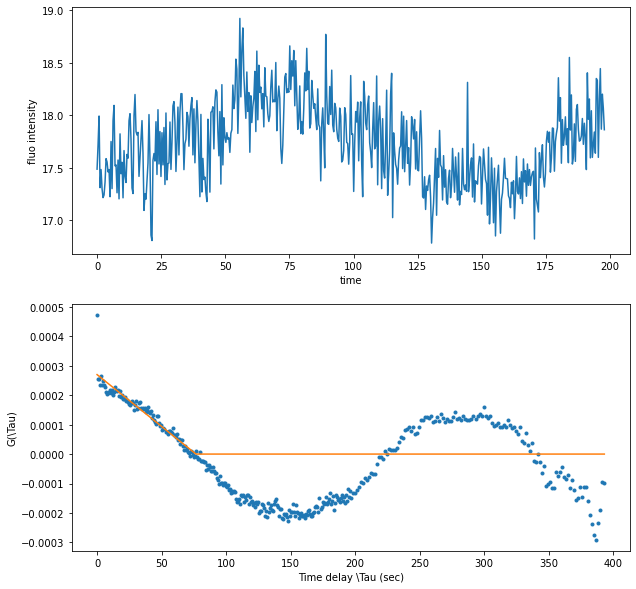

In [272]:
# Analyse one track
# Choose your track id
id_= np.unique(datas.TRACK_ID)[0]
id_ = 18
print(id_)

x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/2**16*100
fig, ax = plt.subplots(2,1)
ax[0].plot(x,y)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
if (mm%2)==0: 
    autocor = multipletau.autocorrelate(y,
                                    m=mm,
                                    deltat=DELTA_T, 
                                    normalize=True)
else: 
    autocor = multipletau.autocorrelate(y,
                                    m=mm+1,
                                    deltat=DELTA_T,
                                    normalize=True)



popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2],
                            autocor.flatten()[1::2], 
                            method='lm' )

print(popt)
print(1200/popt)
ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.')
ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")

fig.set_size_inches((10,10))

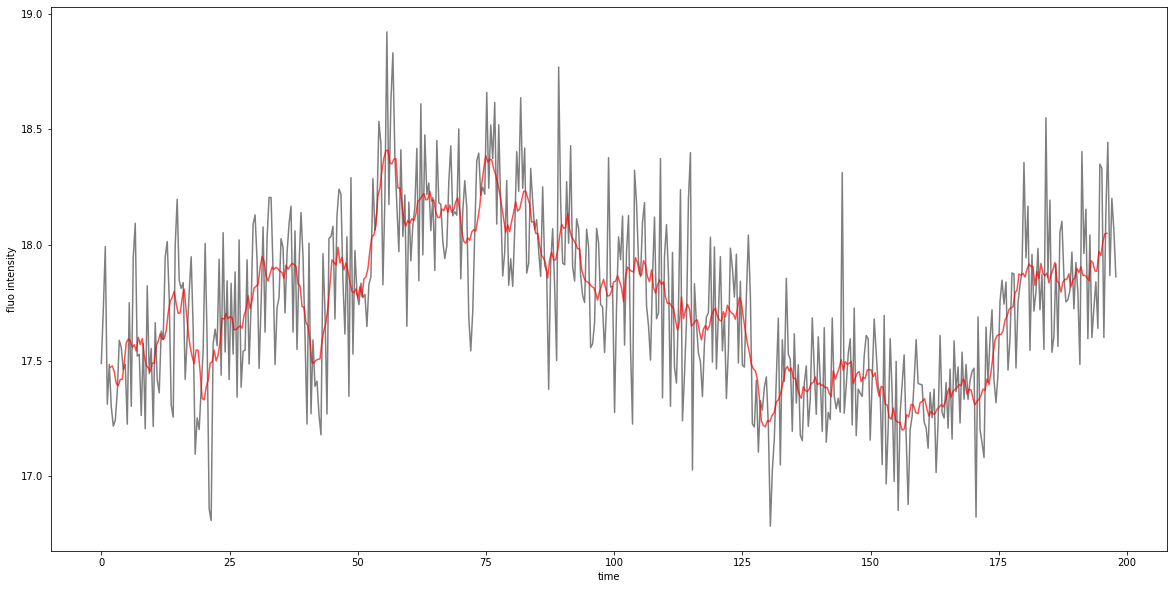

In [273]:
# Moyenne par fenetre glissante
from collections import deque
def fenetre_glissante(sequence, k):
    """Calcule une moyenne sur des fenêtres glissantes.
    k est la taille de la fenêtre glissante
 
    >>> fenetre_glissante([40, 30, 50, 46, 39, 44], 3)
    [40.0, 42.0, 45.0, 43.0]
    """
    d = deque(sequence[:k])  # on initialise avec les k premiers élements
    avg, s = [], sum(d)
    avg.append(s / k)  # la moyenne sur la fenêtre
 
    for elt in sequence[k:]:
        s += elt - d.popleft()  # on enlève la 1re valeur, on ajoute la nouvelle
        d.append(elt)
        avg.append(s / k)
 
    return avg
y_gliss = fenetre_glissante(y, 10)
x_gliss = fenetre_glissante(x, 10)

fig, ax = plt.subplots(1,1)
ax.plot(x,y, color='black', alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("fluo intensity")
ax.plot(x_gliss, y_gliss, color='red', alpha=0.7)
fig.set_size_inches((20,10))


[79.13435961 47.68234474]
[15.16408303 25.16654763]


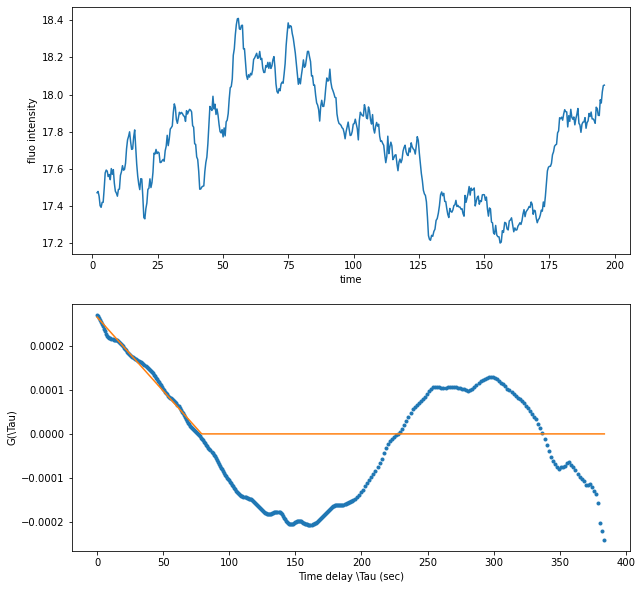

In [274]:
fig, ax = plt.subplots(2,1)
ax[0].plot(x_gliss,y_gliss)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

mm = int(len(y_gliss)/2-1)
if (mm%2)==0: 
    autocor = multipletau.autocorrelate(y_gliss,
                                    m=mm,
                                    deltat=DELTA_T, 
                                    normalize=True)
else: 
    autocor = multipletau.autocorrelate(y_gliss,
                                    m=mm+1,
                                    deltat=DELTA_T,
                                    normalize=True)



popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2],
                            autocor.flatten()[1::2], 
                            method='lm' )

print(popt)
print(1200/popt)
ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.')
ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
fig.set_size_inches((10,10))

In [282]:
y_sub = y[::2]
x_sub = x[::2]

# fig, ax = plt.subplots(1,1)
# ax.plot(x,y, color='black', alpha=0.5)
# ax.set_xlabel("time")
# ax.set_ylabel("fluo intensity")
# ax.plot(x_gliss, y_gliss, color='red', alpha=0.7)
# ax.plot(x_sub, y_sub, color='blue', alpha=0.7)
# fig.set_size_inches((20,10))

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y,
                    mode='lines',
                    name='original',
                    line = dict(color='black'), opacity=0.6))
fig.add_trace(go.Scatter(x=x_gliss, y=y_gliss,
                    mode='lines',
                    name='sliding window',
                  line = dict(color='red'), opacity=0.7))
fig.add_trace(go.Scatter(x=x_sub, y=y_sub,
                    mode='lines',
                    name='sub-sampled',
                  line = dict(color='green'), opacity=1))

fig.show()


[0.60755197 1.        ]
[1975.13968222 1200.        ]


/home/u2175049/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning:

Covariance of the parameters could not be estimated



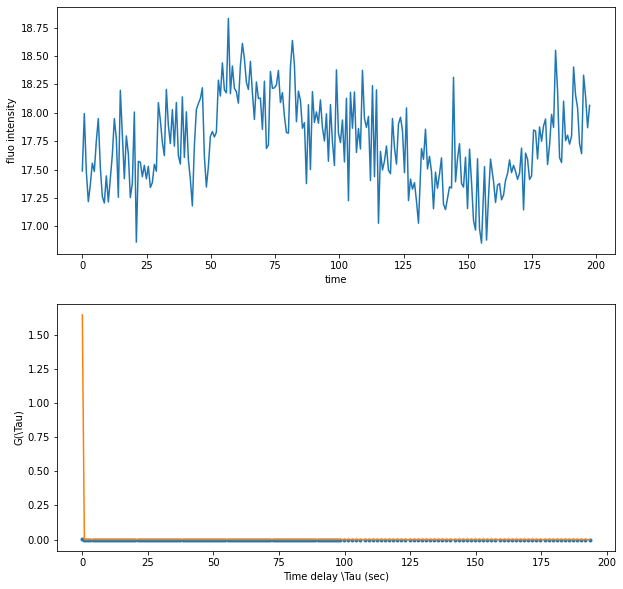

In [276]:
fig, ax = plt.subplots(2,1)
ax[0].plot(x_sub,y_sub)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

mm = int(len(y_sub)/2-1)
if (mm%2)==0: 
    autocor = multipletau.autocorrelate(y_sub,
                                    m=mm,
                                    deltat=DELTA_T, 
                                    normalize=True)
else: 
    autocor = multipletau.autocorrelate(y_sub,
                                    m=mm+1,
                                    deltat=DELTA_T,
                                    normalize=True)



popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2][1:],
                            autocor.flatten()[1::2][1:], 
                            method='lm' )

print(popt)
print(1200/popt)
ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.')
ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
fig.set_size_inches((10,10))

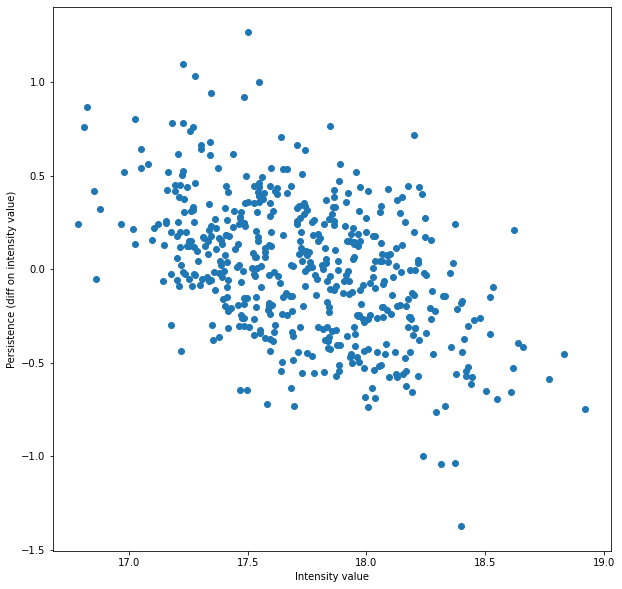

In [277]:
fig, ax = plt.subplots()
ax.scatter(y[:-1], np.diff(y))
ax.set_xlabel("Intensity value")
ax.set_ylabel("Persistence (diff on intensity value)")
fig.set_size_inches((10,10))

In [122]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x[1:], y=np.diff(y),
                    mode='lines',
                    name='lines',
                    line = dict(color='black'), opacity=0.8))
fig.add_trace(go.Scatter(x=x[::2][1:], y=np.diff(y[::2]),
                    mode='lines',
                    name='lines',
                  line = dict(color='red'), opacity=0.7))

fig.show()



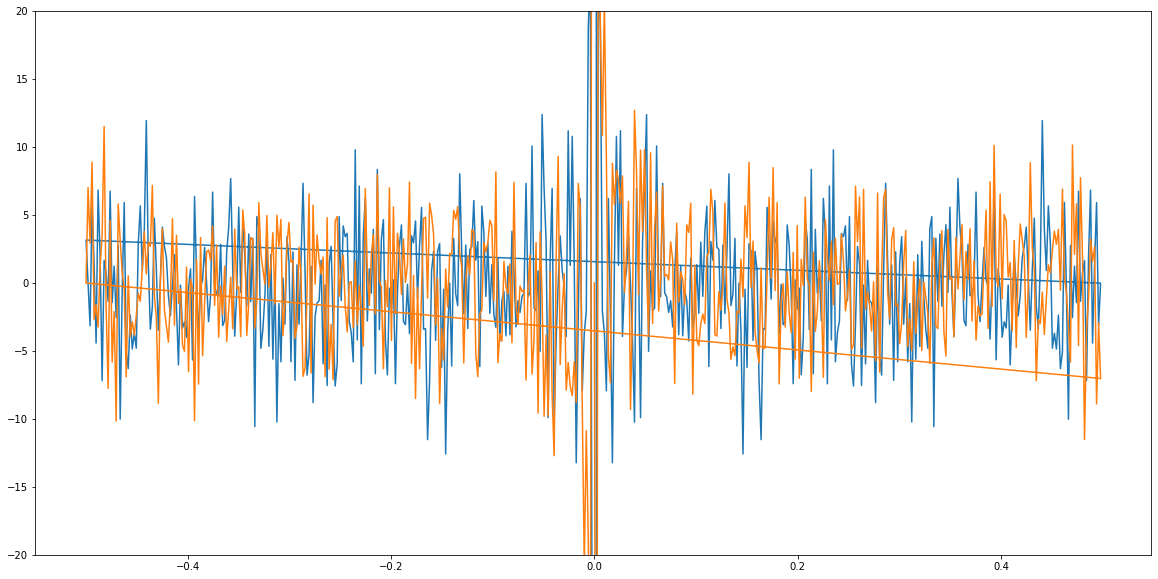

In [141]:
sp = np.fft.fft(y)
freq = np.fft.fftfreq(y.shape[-1])
fig, ax = plt.subplots()
ax.plot(freq, sp.real)
ax.plot(freq, sp.imag)
ax.set_ylim(-20,20)
fig.set_size_inches((20,10))

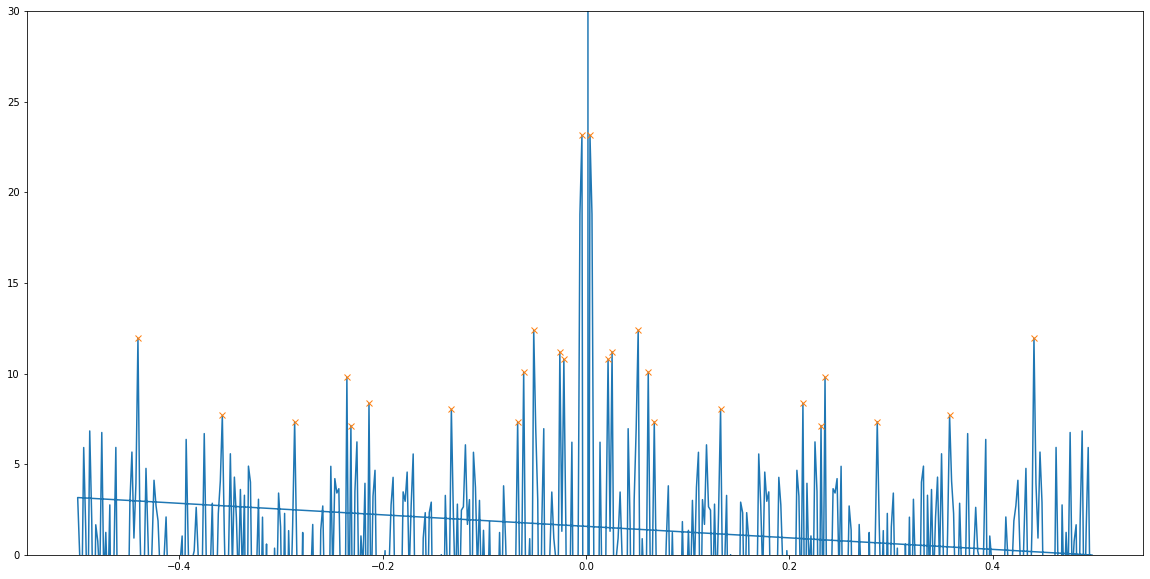

In [169]:
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
# Number of samples in normalized_tone
N = 0.39 * len(y)

yf = rfft(y)
xf = rfftfreq(len(y), 0.39)

fig, ax = plt.subplots()
ax.plot(freq, sp.real)
ax.set_ylim(0,30)
fig.set_size_inches((20,10))

from scipy.signal import find_peaks
peaks_index, properties = find_peaks(sp.real, height=7 )
ax.plot(freq[peaks_index], sp.real[peaks_index], 'x')

In [170]:
sp.real[peaks_index]

array([23.15543343, 10.78930232, 11.20135296, 12.3918641 , 10.0820489 ,
        7.32908937,  8.02974031,  8.35988739,  7.13521883,  9.80285727,
        7.34190598,  7.69176333, 11.95573205, 11.95573205,  7.69176333,
        7.34190598,  9.80285727,  7.13521883,  8.35988739,  8.02974031,
        7.32908937, 10.0820489 , 12.3918641 , 11.20135296, 10.78930232,
       23.15543343])

In [267]:
freq[peaks_index]*100

array([  0.39525692,   2.17391304,   2.56916996,   5.13833992,
         6.12648221,   6.71936759,  13.24110672,  21.34387352,
        23.12252964,  23.51778656,  28.65612648,  35.77075099,
        44.07114625, -44.07114625, -35.77075099, -28.65612648,
       -23.51778656, -23.12252964, -21.34387352, -13.24110672,
        -6.71936759,  -6.12648221,  -5.13833992,  -2.56916996,
        -2.17391304,  -0.39525692])

# plot all track that was keep in result table

In [9]:
# read one file
# path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/02-Long-Movie/SnailCoreTATA/"
# files = [
#     "Snail CT 071222 E3_1_track.csv"
# ]

f = path+files[0]

datas = pd.read_csv(f)
datas.drop(index=[0,1,2], inplace=True)
datas['FRAME'] = pd.to_numeric(datas["FRAME"])
datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])

In [10]:
columns = ['file_name', 'track_id','len_track', 'elongation_time', 'init_translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]

datas = pd.read_csv(f)
datas.drop(index=[0,1,2], inplace=True)
datas['FRAME'] = pd.to_numeric(datas["FRAME"])
datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])



for id_ in np.unique(datas['TRACK_ID']):

    x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
    y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values-np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values)

    mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
    if (mm%2)==0: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm,
                                        deltat=DELTA_T, 
                                        normalize=True)
    else: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm+1,
                                        deltat=DELTA_T,
                                        normalize=True)



    popt, pcov = optimize.curve_fit(func_, 
                                autocor.flatten()[0::2],
                                autocor.flatten()[1::2], 
                                method='lm' )
    if popt[0]>5:
        d = pd.DataFrame.from_dict({'file_name':f.split('/')[-2],
                                    'track_id':id_,
                                    'len_track': len(x),
                                    'elongation_time':popt[0],
                                    'init_translation_rate':popt[1]},
                                   orient='index').T
        result = pd.concat([result, d], ignore_index=True)

# result.drop(result[result["len_track"]<100].index, inplace=True)
result['elongation_time_norm'] = 1300/result['elongation_time']
result['init_translation_rate_norm'] = result['init_translation_rate']
result['tmp'] = 1

In [11]:
result

,file_name,track_id,len_track,elongation_time,init_translation_rate,elongation_time_norm,init_translation_rate_norm,tmp
0,SnailCoreTATA,18,506,38.3334,0.280053,33.912985,0.280053,1
1,SnailCoreTATA,20,426,43.228894,0.167933,30.072479,0.167933,1
2,SnailCoreTATA,78,426,33.540214,0.505238,38.759442,0.505238,1


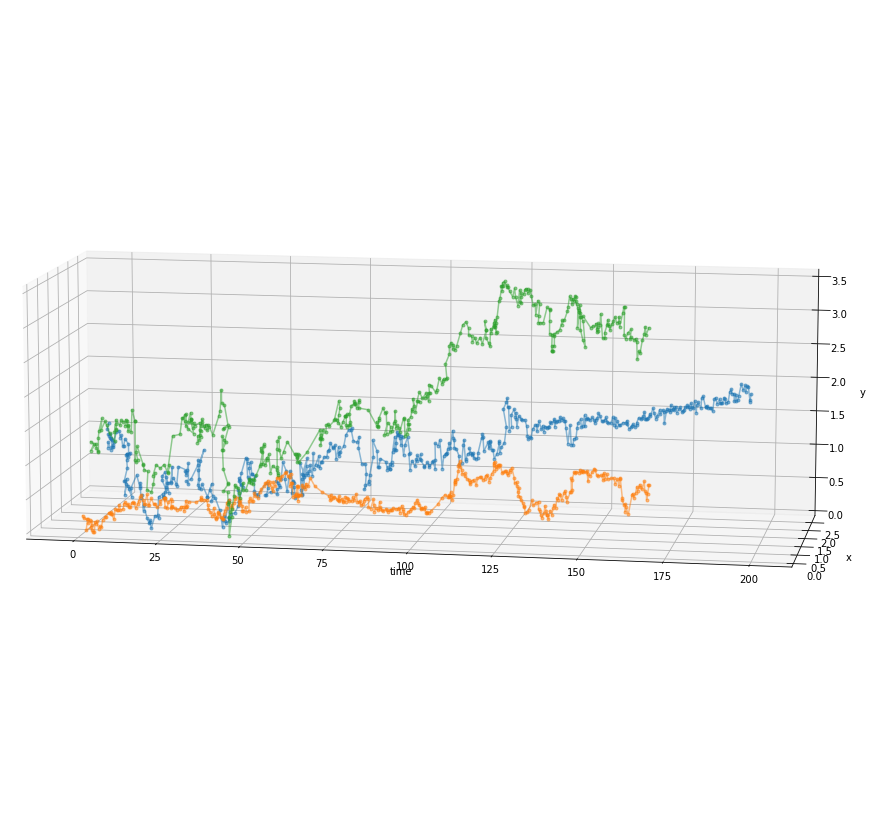

In [12]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.5, 1]))
ax.set_box_aspect(aspect = (3,1,1))


for id_ in np.unique(result['track_id'].to_numpy()):
    x = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()))
    y = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()))
    z = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()))
    
    ax.plot(x, 
            y, 
            z, 
            '.-',
            alpha = 0.5
            )

ax.set_xlabel('time')
ax.set_ylabel('x')
ax.set_zlabel('y')
fig.set_size_inches((15, 15))

ax.view_init(elev=10., azim=-80)

2


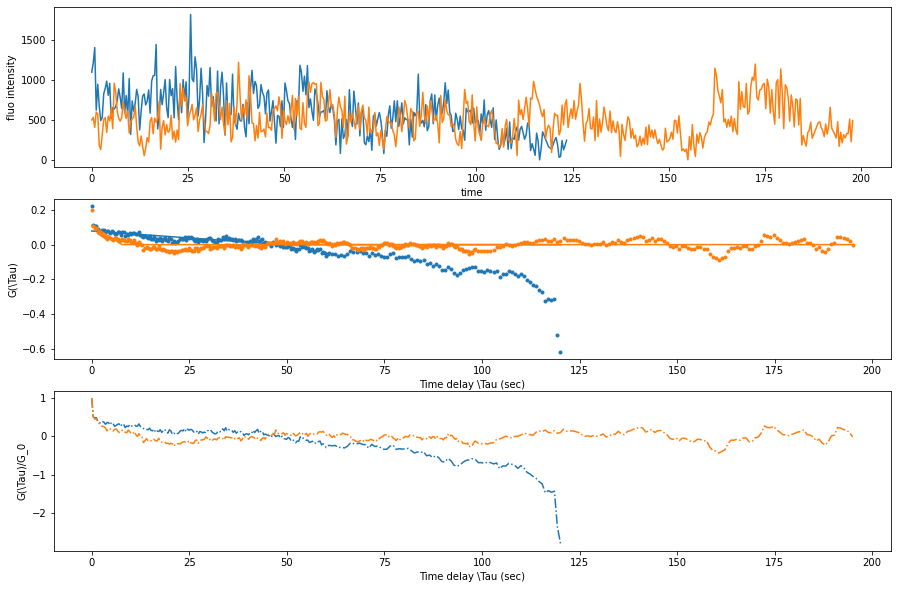

In [181]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(3,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
for id_ in np.unique(result['track_id']):#[:5]:

    x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
    y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values-np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values)
    
    ax[0].plot(x, y, color=colors[i])


    mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
    if (mm%2)==0: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm,
                                        deltat=DELTA_T, 
                                        normalize=True)
    else: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm+1,
                                        deltat=DELTA_T,
                                        normalize=True)



    popt, pcov = optimize.curve_fit(func_, 
                                autocor.flatten()[0::2],
                                autocor.flatten()[1::2], 
                                method='lm' )


    ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.', color=colors[i])
    ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt), color=colors[i] )
    
    ax[2].plot(autocor.flatten()[0::2], autocor.flatten()[1::2]/autocor.flatten()[1], '-.', color=colors[i])
    
    
    if i == 7:
        i=0
    else:
        i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")

ax[2].set_xlabel("Time delay \Tau (sec)")
ax[2].set_ylabel("G(\Tau)/G_0")

fig.set_size_inches((15,10))
print(len(np.unique(result['track_id'])))

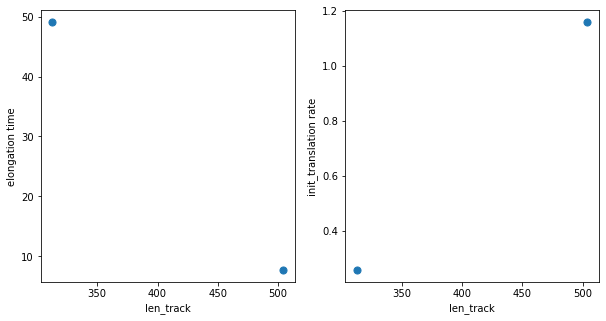

In [182]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(result['len_track'], result['elongation_time'], s=50)
ax[1].scatter(result['len_track'], result['init_translation_rate'], s=50)
ax[0].set_xlabel('len_track')
ax[0].set_ylabel('elongation time')

ax[1].set_xlabel('len_track')
ax[1].set_ylabel('init_translation rate')
fig.set_size_inches((10,5))

# Multiple file analysis

In [264]:
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/02-Long-Movie/SnailCoreTATA/"
files = [
        "Snail CT 061222 E1_1_track.csv",
        "Snail CT 061222 E1_2_track.csv",
        "Snail CT 061222 E1_3_track.csv",
        "Snail CT 061222 E2_1_track.csv",
        'Snail CT 071222 E2_1_track.csv',
        'Snail CT 071222 E2_2_track.csv',
        "Snail CT 071222 E3_1_track.csv",
        "Snail CT 071222 E3_3_track.csv",
    
        ]
DELTA_T = 0.39
DELTA_T = 2*DELTA_T
print(DELTA_T)

0.78


In [265]:
columns = ['file_name', 'track_id','len_track', 'elongation_time', 'init_translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]
for f in files:
    f = path+f
    datas = pd.read_csv(f)
    datas.drop(index=[0,1,2], inplace=True)
    datas['FRAME'] = pd.to_numeric(datas["FRAME"])
    datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
    datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
    datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
    datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
    datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])
    


    for id_ in np.unique(datas['TRACK_ID']):
        
        x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
        y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values)
        x = x[::2]
        y = y[::2]
#         y = fenetre_glissante(y, 20)
#         x = fenetre_glissante(x, 20)
        mm = int(len(y)/2-1)
        if (mm%2)==0: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm,
                                            deltat=DELTA_T, 
                                            normalize=True)
        else: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm+1,
                                            deltat=DELTA_T,
                                            normalize=True)



        popt, pcov = optimize.curve_fit(func_, 
                                    autocor.flatten()[0::2],
                                    autocor.flatten()[1::2], 
                                    method='lm' )
        if popt[0]>5:
            d = pd.DataFrame.from_dict({'file_name':f.split('/')[-1],
                                        'track_id':id_,
                                        'len_track': len(x)*DELTA_T,
                                        'elongation_time':popt[0],
                                        'init_translation_rate':popt[1]},
                                       orient='index').T
            result = pd.concat([result, d], ignore_index=True)

result['elongation_time_norm'] = 1300/result['elongation_time']
result['init_translation_rate_norm'] = result['init_translation_rate']
result['tmp'] = 1
# result.drop(result[result["len_track"]<100].index, inplace=True)

In [263]:
# result.sort_values('len_track')
result

,file_name,track_id,len_track,elongation_time,init_translation_rate,elongation_time_norm,init_translation_rate_norm,tmp
0,Snail CT 061222 E1_1_track.csv,18,197.34,34.316525,0.319737,34.968576,0.319737,1
1,Snail CT 061222 E1_1_track.csv,20,166.14,42.711548,0.170339,28.095446,0.170339,1
2,Snail CT 061222 E1_2_track.csv,395,156.0,40.872632,0.105303,29.359499,0.105303,1
3,Snail CT 061222 E1_2_track.csv,632,170.04,22.25242,0.581617,53.926719,0.581617,1
4,Snail CT 061222 E1_3_track.csv,59,177.06,50.373431,0.18435,23.822082,0.18435,1
5,Snail CT 061222 E1_3_track.csv,66,175.5,52.192599,0.193681,22.991766,0.193681,1
6,Snail CT 061222 E1_3_track.csv,79,192.66,67.048398,0.108735,17.897519,0.108735,1
7,Snail CT 071222 E3_1_track.csv,21,122.46,45.825848,0.267984,26.186095,0.267984,1


track_id                      161.250000
len_track                     169.650000
elongation_time                44.449175
init_translation_rate           0.241468
elongation_time_norm           32.127293
init_translation_rate_norm      0.241468
tmp                             1.000000
dtype: float64


/tmp/ipykernel_129423/2469479023.py:7: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



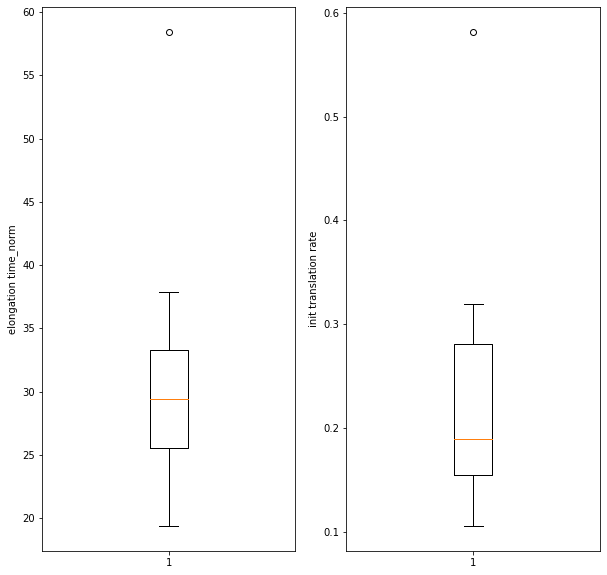

In [266]:
fig, ax = plt.subplots(1, 2)
ax[0].boxplot(result['elongation_time_norm'])
ax[1].boxplot(result['init_translation_rate'])
ax[0].set_ylabel('elongation time_norm')
ax[1].set_ylabel('init translation rate')
fig.set_size_inches((10,10))
print(result.mean())

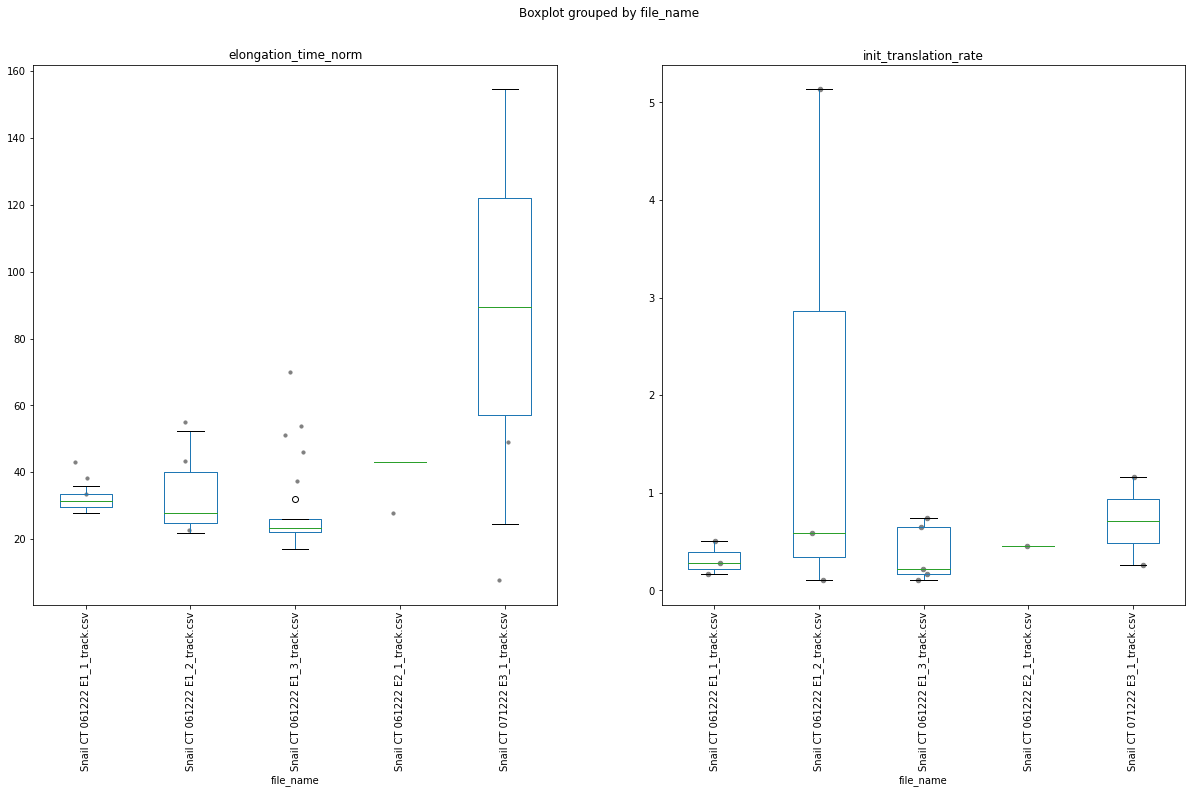

In [24]:
# result['elongation_time'] = pd.to_numeric(result['elongation_time'])
fig, ax = plt.subplots(1,2)
result.boxplot(['elongation_time_norm'] , 
               by='file_name', 
               grid=False, 
               ax = ax[0],
               rot=90, 
              )

result.boxplot([ 'init_translation_rate'] , 
               by='file_name', 
               grid=False, 
               ax = ax[1],
               rot=90
               )

group = 'file_name'
column = 'elongation_time'
grouped = result.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
    
group = 'file_name'
column = 'init_translation_rate'
grouped = result.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
    
# ax[1].set_ylim(0,250)
fig.set_size_inches((20,10))

In [198]:
result.groupby(by='file_name').mean()

,track_id,len_track,elongation_time,init_translation_rate,elongation_time_norm,init_translation_rate_norm
file_name,,,,,,
Snail CT 061222 E1_1_track.csv,38.666667,452.666667,38.367503,0.317741,34.248302,0.317741
Snail CT 061222 E1_2_track.csv,375.000000,447.333333,40.355547,1.943780,36.860050,1.943780
Snail CT 061222 E1_3_track.csv,101.200000,464.000000,51.705609,0.377921,26.218999,0.377921
Snail CT 061222 E2_1_track.csv,66.000000,504.000000,27.936263,0.458285,46.534499,0.458285
Snail CT 071222 E3_1_track.csv,74.500000,408.500000,28.398166,0.708847,96.980389,0.708847


<AxesSubplot:title={'center':'elongation_time_norm'}, xlabel='file_name'>

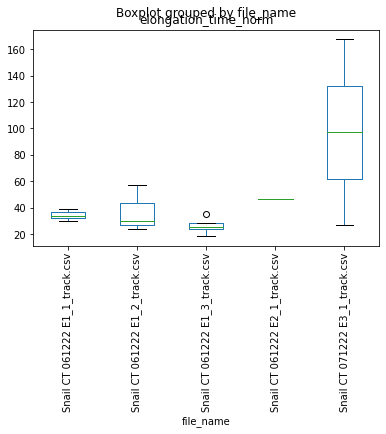

In [201]:
result.boxplot(['elongation_time_norm'] , 
               by='file_name', 
               grid=False, 
#                ax = ax[0],
               rot=90, 
              )

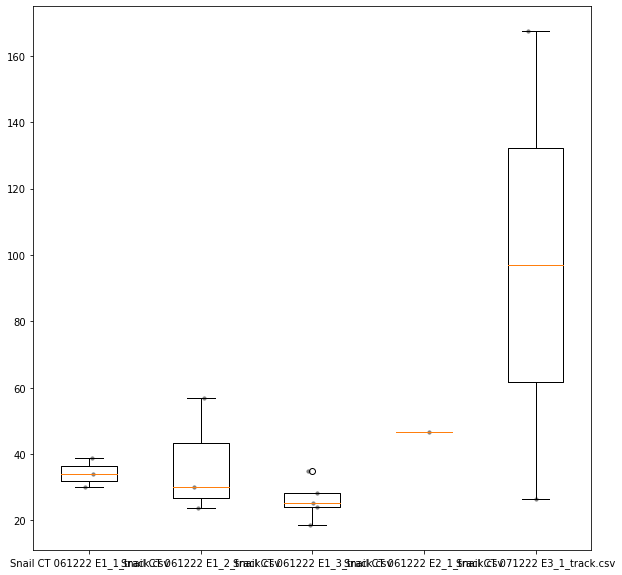

In [192]:
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# initialize dataframe
# n = 200
# ngroup = 3
# df = pd.DataFrame({'data': np.random.rand(n), 'group': map(np.floor, np.random.rand(n) * ngroup)})
fig, ax = plt.subplots()

group = 'file_name'
column = 'elongation_time_norm'
grouped = result.groupby(group)

names, vals, xs = [], [] ,[]

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

ax.boxplot(vals, labels=names, )
ngroup = len(vals)



for x, val, clevel in zip(xs, vals, clevels):
    ax.scatter(x, val, c='grey', alpha=1, s=10)
    
ax.grid(False)
fig.set_size_inches((10,10))

In [214]:
result[["file_name", 'len_track','elongation_time_norm', 'init_translation_rate']]

,file_name,len_track,elongation_time_norm,init_translation_rate
0,Snail CT 061222 E1_1_track.csv,197.34,33.912985,0.280053
1,Snail CT 061222 E1_1_track.csv,166.14,30.072479,0.167933
2,Snail CT 061222 E1_1_track.csv,166.14,38.759442,0.505238
3,Snail CT 061222 E1_2_track.csv,197.73,23.652562,5.135391
4,Snail CT 061222 E1_2_track.csv,156.0,30.062561,0.106275
5,Snail CT 061222 E1_2_track.csv,169.65,56.865027,0.589674
6,Snail CT 061222 E1_3_track.csv,176.67,24.112243,0.168479
7,Snail CT 061222 E1_3_track.csv,175.11,25.388879,0.218547
8,Snail CT 061222 E1_3_track.csv,192.66,18.579373,0.109104
9,Snail CT 061222 E1_3_track.csv,184.86,34.814287,0.647431


In [215]:
result[["file_name", 'len_track','elongation_time_norm', 'init_translation_rate']].mean()

/tmp/ipykernel_111383/2480877291.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result[["file_name", 'len_track','elongation_time_norm', 'init_translation_rate']].mean()


len_track                176.642143
elongation_time_norm      41.779666
init_translation_rate      0.753582
dtype: float64

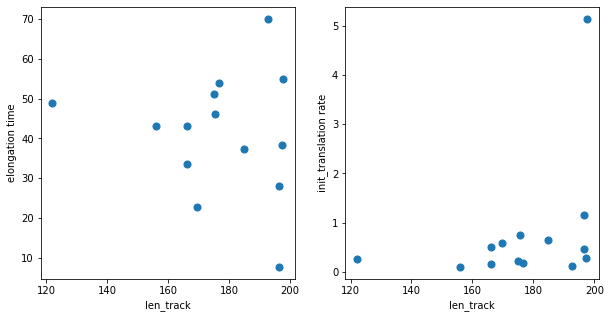

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(result['len_track'], result['elongation_time'], s=50)
ax[1].scatter(result['len_track'], result['init_translation_rate'], s=50)
ax[0].set_xlabel('len_track')
ax[0].set_ylabel('elongation time')

ax[1].set_xlabel('len_track')
ax[1].set_ylabel('init_translation rate')
fig.set_size_inches((10,5))